In [1]:
# This needs to be here because by default Jupyter only adds the pwd to sys.path
import os, sys
if os.path.abspath('..') not in sys.path: sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np

from pysrc.constants import cachepath, datapath, chartpath
import torch
import time
from torch.utils.data import DataLoader

c:\users\nick\appdata\local\programs\python\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dict = {}
test_dict = {}

with open(datapath("train.txt")) as file:
    for line in file:
        (user_id, items) = line.split(maxsplit=1)
        train_dict[user_id] = items

with open(datapath("test.txt")) as file:
    for line in file:
        split = line.split(maxsplit=1)
        if (len(split) > 1):
            (user_id, items) = split
            test_dict[user_id] = items
        else:
            test_dict[split[0]] = ''


In [3]:
train = []
test = []
for key in train_dict:
    train.append([int(n) for n in train_dict[key].replace('\n', '').split(' ')])

for key in test_dict:
    if len(test_dict[key]) == 0:
        test.append([])
    else:
        test.append([int(n) for n in test_dict[key].replace('\n', '').split(' ')])
        

In [4]:
x = torch.rand((10,5))
x

tensor([[0.6618, 0.5402, 0.5261, 0.2717, 0.1531],
        [0.6600, 0.0953, 0.1120, 0.3229, 0.6607],
        [0.0976, 0.6895, 0.8819, 0.8196, 0.9451],
        [0.9582, 0.0252, 0.0738, 0.3989, 0.3708],
        [0.8952, 0.2340, 0.0839, 0.0167, 0.2074],
        [0.2726, 0.2307, 0.2551, 0.5216, 0.2217],
        [0.0759, 0.3380, 0.0304, 0.7321, 0.2724],
        [0.5925, 0.0262, 0.7280, 0.6385, 0.5871],
        [0.8510, 0.1485, 0.3393, 0.8515, 0.9175],
        [0.2377, 0.0410, 0.9269, 0.8762, 0.1720]])

In [5]:
x.sum(axis = 1)

tensor([2.1529, 1.8510, 3.4337, 1.8269, 1.4372, 1.5016, 1.4490, 2.5723, 3.1078,
        2.2538])

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor


def log_likelihood_loss(y, yhat):
    return -torch.mean(torch.sum(torch.log(yhat+1e-6) * y, axis = 1))

def likelihood_loss(y, yhat):
    return -torch.mean(torch.sum(yhat * y, axis = 1))

class VanillaVAE(nn.Module):


    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 hidden_dims = None,
                 kl_weight = .2
                 ):
        super(VanillaVAE, self).__init__()
        
        self.kl_weight = kl_weight

        self.latent_dim = latent_dim
        
        modules = []
        
        if hidden_dims is None:
            hidden_dims = [512, 128]
            
        self.hidden_dims = hidden_dims
            
        modules.append(nn.Linear(input_dim, hidden_dims[0]))
        modules.append(nn.BatchNorm1d(hidden_dims[0]))
        modules.append(nn.LeakyReLU())
        
        # Build Encoder
        for i in range(len(hidden_dims)-1):
            modules.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            modules.append(nn.BatchNorm1d(hidden_dims[i+1]))
            modules.append(nn.LeakyReLU())

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            modules.append(nn.BatchNorm1d(hidden_dims[i+1]))
            modules.append(nn.LeakyReLU())



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(nn.Linear(hidden_dims[-1], input_dim),
                                         nn.Sigmoid()
                                        )
        

    def encode(self, input: Tensor):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[0])
        result = self.decoder(result)
        result = self.final_layer(result)
        result = F.normalize(result, p=1)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x: Tensor, **kwargs):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return  [F.normalize(self.decode(z), 1, dim=1), x, mu, log_var]

    def loss_function(self, recons, x, mu, log_var) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        

        kld_weight = self.kl_weight
        recons_loss = log_likelihood_loss(x, recons)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [7]:
item_dim = 91599
np.random.seed(0)
test_ids = np.random.choice(np.array(list(train_dict.keys())).astype(int), int(.2*len(train_dict.keys())), replace=False)

In [8]:
def sparsify_uniform(data, p_relative = .1):
    current_sparse = None
    batch_size = 1000
    X = []
    for row in data:
        X.append(torch.zeros(item_dim).bool())
        for item in row:
            if np.random.random() > p_relative:
                X[-1][item] = 1
        X[-1] = X[-1]
    X = torch.stack(X)
    return X
    
def sparsify_items(data, m, sigma):
    return

def sparsify_users(data, m, sigma):
    return

def list_batch_to_ohe(data):
    return sparsify_uniform(data, 0)

dev_df = pd.Series(train).drop(test_ids)
test_in = pd.Series(train).iloc[test_ids]
test_out = pd.Series(test).iloc[test_ids]

train_df = dev_df.iloc[:int(.7*len(dev_df))]
val_df = dev_df.iloc[int(.7*len(dev_df)):]

train_tensor = list_batch_to_ohe(train_df)
val_tensor = list_batch_to_ohe(val_df)
test_in_tensor = list_batch_to_ohe(test_in)
test_out_tensor = list_batch_to_ohe(test_out)

In [12]:
def train_model(model, train, val):
    for epoch in range(n_epochs):
        if epoch % 10 == 0:
            print(f"Start Epoch {epoch}")
        model.train()
        start_time = time.time()
        total_loading_time = 0
        for batch_X in train:
            batch_X = batch_X.float().cuda()
            recons, x, mu, log_var = model.forward(batch_X)
            train_loss = model.loss_function(recons, x, mu, log_var)['loss']
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            model.eval()
            total_train_loss = 0
            r_train_loss = 0
            kl_train_loss = 0
            train_batches = 0
            for batch_X in train:
                batch_X = batch_X.float().cuda()
                recons, x, mu, log_var = model.forward(batch_X)
                loss = model.loss_function(recons, x, mu, log_var)
                total_train_loss += loss['loss']
                r_train_loss += loss['Reconstruction_Loss']
                kl_train_loss += loss['KLD']
                train_batches += 1

            total_train_loss /= train_batches
            r_train_loss /= train_batches
            kl_train_loss /= train_batches

            total_loss = 0
            r_loss = 0
            kl_loss = 0
            batches = 0
            for batch_X in val:
                batch_X = batch_X.float().cuda()
                recons, x, mu, log_var = model.forward(batch_X)
                loss = model.loss_function(recons, x, mu, log_var)
                total_loss += loss['loss']
                r_loss += loss['Reconstruction_Loss']
                kl_loss += loss['KLD']
                batches += 1

            total_loss /= batches
            r_loss /= batches
            kl_loss /= batches
def top_k_recall(X_in, X_out, X_target, k = 20, mask_in = True):
    if mask_in:
        mask = X_in == False
        X_out = X_out * mask
    topk = torch.topk(X_out, k)
    n = 0
    total_recall = 0
    for i in range(len(X_in)):
        if int(X_target[i].sum()) == 0:
            continue
        selected = topk.indices[i]
        total_recall += X_target[i][selected].sum() / X_target[i].sum()
        n += 1
    
    return total_recall / n

def n_recall(X_in, X_out, X_target, mask_in = True):
    if mask_in:
        mask = X_in == False
        X_out = X_out * mask
    topk = torch.topk(X_out, int(X_target.sum(axis=1).max()), sorted=True)
    n = 0
    total_recall = 0
    for i in range(len(X_in)):
        if int(X_target[i].sum()) == 0:
            continue
        selected = topk.indices[i]
        total_recall += X_target[i][selected[:int(X_target[i].sum())]].sum() / int(X_target[i].sum())
        n += 1
    #print(total_recall,n)
    #print(len(X_in))
    return total_recall / len(X_in)

In [14]:
n_epochs = 100
batch_size = 256

results = {}

for sparsity in [0, .01, .02, .03, .05, .1, .2, .3, .4, .5, .6, .7, .9]:
    print()
    print("Starting sparsity", sparsity)
    start = time.time()
    train_tensor = sparsify_uniform(train_df, p_relative = sparsity)
    lr = 1e-3
    model = VanillaVAE(input_dim = item_dim, latent_dim = 256, hidden_dims = [1024, 512], kl_weight = 10).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    train_dataloader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_tensor, batch_size=batch_size, shuffle=True)
    train_model(model, train_dataloader, val_dataloader)
    
    model.eval()
    test_ind_dataloader = DataLoader(torch.Tensor(range(len(test_in_tensor))).long(), batch_size=batch_size, shuffle=True)
    with torch.no_grad():
        total_n_recall_train = 0
        total_n_train = 0
        for batch_X in train_dataloader:
            batch_out = model.forward(batch_X.float().cuda())[0].detach().cpu()
            n_recall_batch = n_recall(batch_X, batch_out, batch_X, False)
            total_n_recall_train += n_recall_batch * len(batch_X)
            total_n_train += len(batch_X)
        print("Train recons recall:", total_n_recall_train / total_n_train)
        train_recons_recall = total_n_recall_train / total_n_train
        
        total_n_recall_recons = 0
        total_n_recons = 0
        for batch_ind in test_ind_dataloader:
            batch_in = test_in_tensor[batch_ind].float()
            batch_target = test_out_tensor[batch_ind].float()
            batch_out = model.forward(batch_in.cuda())[0].detach().cpu()
            n_recall_batch = n_recall(batch_in, batch_out, batch_in, False)
            total_n_recall_recons += n_recall_batch * len(batch_ind)
            total_n_recons += len(batch_ind)
        print("Test recons recall:", total_n_recall_recons / total_n_recons)
        test_recons_recall = total_n_recall_recons / total_n_recons
        
        
        total_n_recall_out = 0
        total_n_out = 0
        for batch_ind in test_ind_dataloader:
            batch_in = test_in_tensor[batch_ind].float()
            batch_target = test_out_tensor[batch_ind].float()
            batch_out = model.forward(batch_in.cuda())[0].detach().cpu()
            n_recall_batch = n_recall(batch_in, batch_out, batch_target, True)
            total_n_recall_out += n_recall_batch * len(batch_ind)
            total_n_out += len(batch_ind)
        print("Test outsample recall:", total_n_recall_out / total_n_out)
        test_outsample_recall = total_n_recall_out / total_n_out
    results[sparsity] = {"train_recons": train_recons_recall, "test_recons": test_recons_recall, "test_out": test_outsample_recall}


Starting sparsity 0
Start Epoch 0
Start Epoch 10
Start Epoch 20
Start Epoch 30
Start Epoch 40
Start Epoch 50
Start Epoch 60
Start Epoch 70
Start Epoch 80
Start Epoch 90
Train recons recall: tensor(0.0632)
Test recons recall: tensor(0.0469)
Test outsample recall: tensor(0.0062)

Starting sparsity 0.01
Start Epoch 0
Start Epoch 10
Start Epoch 20
Start Epoch 30
Start Epoch 40
Start Epoch 50
Start Epoch 60
Start Epoch 70
Start Epoch 80
Start Epoch 90
Train recons recall: tensor(0.0654)
Test recons recall: tensor(0.0491)
Test outsample recall: tensor(0.0069)

Starting sparsity 0.02
Start Epoch 0
Start Epoch 10
Start Epoch 20
Start Epoch 30
Start Epoch 40
Start Epoch 50
Start Epoch 60
Start Epoch 70
Start Epoch 80
Start Epoch 90
Train recons recall: tensor(0.0544)
Test recons recall: tensor(0.0429)
Test outsample recall: tensor(0.0058)

Starting sparsity 0.03
Start Epoch 0
Start Epoch 10
Start Epoch 20
Start Epoch 30
Start Epoch 40
Start Epoch 50
Start Epoch 60
Start Epoch 70
Start Epoch 80

In [21]:
import pandas as pd
import pickle

In [1]:
results = {}
results[0] = {"train_recons": .0632, "test_recons": .0469, "test_out": .0062}
results[0.01] = {"train_recons": .0654, "test_recons": .0491, "test_out": .0069}
results[0.02] = {"train_recons": .0544, "test_recons": .0429, "test_out": .0058}
results[0.03] = {"train_recons": .0561, "test_recons": .0447, "test_out": .0065}
results[0.05] = {"train_recons": .0608, "test_recons": .0476, "test_out": .0069}
results[0.1] = {"train_recons": .0495, "test_recons": .0428, "test_out": .0060}
results[0.2] = {"train_recons": .0323, "test_recons": .0334, "test_out": .0049}
results[0.3] = {"train_recons": .0303, "test_recons": .0351, "test_out": .0051}
results[0.4] = {"train_recons": .0224, "test_recons": .0307, "test_out": .0046}
results[0.5] = {"train_recons": .0108, "test_recons": .0183, "test_out": .0032}
results[0.6] = {"train_recons": .009, "test_recons": .0185, "test_out": .0032}
results[0.7] = {"train_recons": .0068, "test_recons": .0178, "test_out": .0031}
results[0.9] = {"train_recons": .0029, "test_recons": .0128, "test_out": .0024}

In [6]:
res_df = pd.DataFrame(results).T

In [23]:
pickle.dump(res_df, open("./midpoint_results.pkl", "wb"))

In [7]:
import matplotlib.pyplot as plt

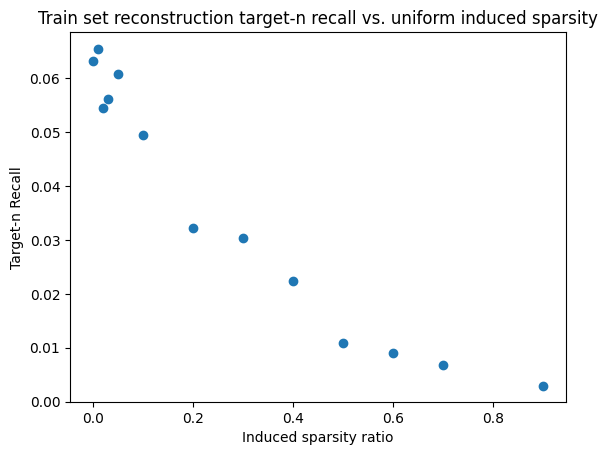

In [18]:
f, ax = plt.subplots(1)
plt.scatter(res_df.index, res_df['train_recons'])
plt.title("Train set reconstruction target-n recall vs. uniform induced sparsity")
plt.xlabel("Induced sparsity ratio")
plt.ylabel("Target-n Recall")
ax.set_ylim(ymin=0)
plt.show()

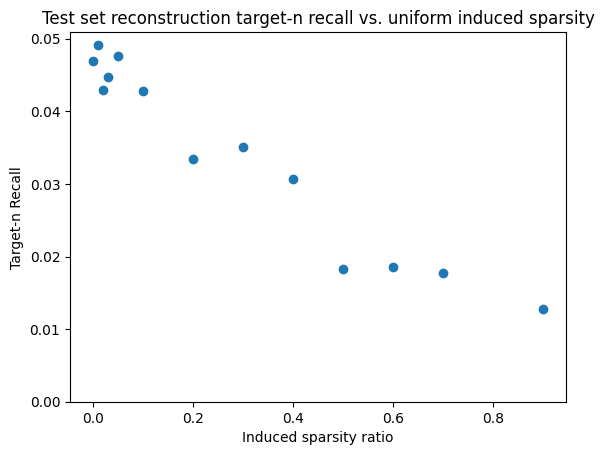

In [9]:
f, ax = plt.subplots(1)
plt.scatter(res_df.index, res_df['test_recons'])
plt.title("Test set reconstruction target-n recall vs. uniform induced sparsity")
plt.xlabel("Induced sparsity ratio")
plt.ylabel("Target-n Recall")
ax.set_ylim(ymin=0)
plt.show()

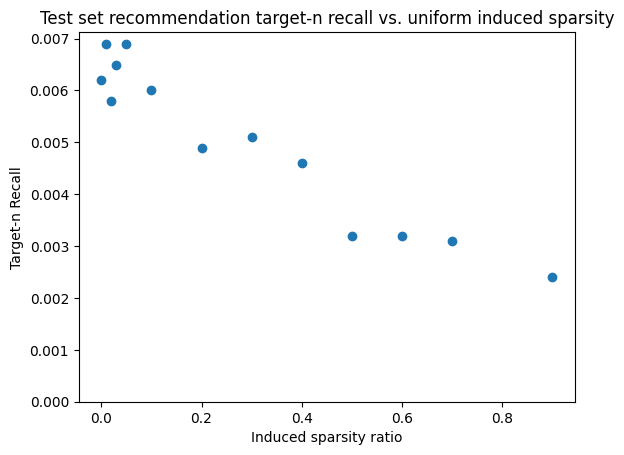

In [16]:
f, ax = plt.subplots(1)
plt.scatter(res_df.index, res_df['test_out'])
plt.title("Test set recommendation target-n recall vs. uniform induced sparsity")
plt.xlabel("Induced sparsity ratio")
plt.ylabel("Target-n Recall")
ax.set_ylim(ymin=0)
plt.show()

In [122]:
lr = 1e-3
model = VanillaVAE(input_dim = item_dim, latent_dim = 236, hidden_dims = [1024, 512], kl_weight = 10).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

In [123]:
n_epochs = 100
batch_size = 256

train_dataloader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

In [124]:
for epoch in range(n_epochs):
    print(f"Start Epoch {epoch}")
    model.train()
    start_time = time.time()
    total_loading_time = 0
    for batch_X in train_dataloader:
        batch_X = batch_X.float().cuda()
        recons, x, mu, log_var = model.forward(batch_X)
        train_loss = model.loss_function(recons, x, mu, log_var)['loss']
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        model.eval()
        total_train_loss = 0
        r_train_loss = 0
        kl_train_loss = 0
        train_batches = 0
        for batch_X in train_dataloader:
            batch_X = batch_X.float().cuda()
            recons, x, mu, log_var = model.forward(batch_X)
            loss = model.loss_function(recons, x, mu, log_var)
            total_train_loss += loss['loss']
            r_train_loss += loss['Reconstruction_Loss']
            kl_train_loss += loss['KLD']
            train_batches += 1

        total_train_loss /= train_batches
        r_train_loss /= train_batches
        kl_train_loss /= train_batches

        total_loss = 0
        r_loss = 0
        kl_loss = 0
        batches = 0
        for batch_X in val_dataloader:
            batch_X = batch_X.float().cuda()
            recons, x, mu, log_var = model.forward(batch_X)
            loss = model.loss_function(recons, x, mu, log_var)
            total_loss += loss['loss']
            r_loss += loss['Reconstruction_Loss']
            kl_loss += loss['KLD']
            batches += 1

        total_loss /= batches
        r_loss /= batches
        kl_loss /= batches

        print(f'Train loss: {total_train_loss}')
        print(f'Train r loss: {r_train_loss}')
        print(f'Train kl loss: {kl_train_loss}')

        print(f'Val loss: {total_loss}')
        print(f'Val r loss: {r_loss}')
        print(f'Val kl loss: {kl_loss}')
        print()


Start Epoch 0
Train loss: 546.8121337890625
Train r loss: 542.2107543945312
Train kl loss: -0.4601309299468994
Val loss: 407.515380859375
Val r loss: 405.17230224609375
Val kl loss: -0.23431193828582764

Start Epoch 1
Train loss: 538.6158447265625
Train r loss: 535.9301147460938
Train kl loss: -0.2685590982437134
Val loss: 402.2051086425781
Val r loss: 399.5943298339844
Val kl loss: -0.26107802987098694

Start Epoch 2
Train loss: 535.7962036132812
Train r loss: 532.5501708984375
Train kl loss: -0.3245977759361267
Val loss: 399.5986328125
Val r loss: 395.1961669921875
Val kl loss: -0.44025152921676636

Start Epoch 3
Train loss: 538.0470581054688
Train r loss: 534.5067138671875
Train kl loss: -0.35402899980545044
Val loss: 397.6555480957031
Val r loss: 392.61181640625
Val kl loss: -0.5043722987174988

Start Epoch 4
Train loss: 535.378173828125
Train r loss: 529.3984985351562
Train kl loss: -0.5979731678962708
Val loss: 396.79290771484375
Val r loss: 392.1194763183594
Val kl loss: -0.4673

Train loss: 495.5394287109375
Train r loss: 470.6695861816406
Train kl loss: -2.4869918823242188
Val loss: 375.0907287597656
Val r loss: 357.7492980957031
Val kl loss: -1.7341493368148804

Start Epoch 42
Train loss: 494.6913146972656
Train r loss: 473.6729431152344
Train kl loss: -2.1018455028533936
Val loss: 376.93499755859375
Val r loss: 362.3689270019531
Val kl loss: -1.4566086530685425

Start Epoch 43
Train loss: 492.2380065917969
Train r loss: 466.3975524902344
Train kl loss: -2.584052562713623
Val loss: 374.98358154296875
Val r loss: 355.9789733886719
Val kl loss: -1.9004615545272827

Start Epoch 44
Train loss: 502.9842834472656
Train r loss: 467.5653381347656
Train kl loss: -3.541889190673828
Val loss: 375.9797668457031
Val r loss: 356.1628112792969
Val kl loss: -1.981701135635376

Start Epoch 45
Train loss: 492.6273498535156
Train r loss: 466.8477478027344
Train kl loss: -2.5779666900634766
Val loss: 374.40130615234375
Val r loss: 356.5455322265625
Val kl loss: -1.7855710983276

KeyboardInterrupt: 

In [115]:
batch_target.sum(axis=1).max()

tensor(31.)

In [120]:
model.eval()
test_ind_dataloader = DataLoader(torch.Tensor(range(len(test_in_tensor))).long(), batch_size=batch_size, shuffle=True)
with torch.no_grad():
    total_n_recall = 0
    total_n = 0
    for batch_ind in test_ind_dataloader:
        batch_in = test_in_tensor[batch_ind].float()
        batch_target = test_out_tensor[batch_ind].float()
        batch_out = model.forward(batch_in.cuda())[0].detach().cpu()
        n_recall_batch = n_recall(batch_in, batch_out, batch_in, False)
        total_n_recall += n_recall_batch * len(batch_ind)
        total_n += len(batch_ind)
    print("Test n recall:", total_n_recall / total_n)


Test n recall: tensor(0.0315)


In [121]:
model.eval()
test_ind_dataloader = DataLoader(torch.Tensor(range(len(test_in_tensor))).long(), batch_size=batch_size, shuffle=True)
with torch.no_grad():
    total_n_recall = 0
    total_n = 0
    for batch_ind in test_ind_dataloader:
        batch_in = test_in_tensor[batch_ind].float()
        batch_target = test_out_tensor[batch_ind].float()
        batch_out = model.forward(batch_in.cuda())[0].detach().cpu()
        n_recall_batch = n_recall(batch_in, batch_out, batch_target, True)
        total_n_recall += n_recall_batch * len(batch_ind)
        total_n += len(batch_ind)
    print("Test n recall:", total_n_recall / total_n)


Test n recall: tensor(0.0048)


In [119]:
model.eval()
train_ind_dataloader = DataLoader(torch.Tensor(range(len(train_tensor))).long(), batch_size=batch_size, shuffle=True)
with torch.no_grad():
    total_n_recall = 0
    total_n = 0
    for batch_ind in test_ind_dataloader:
        batch_in = train_tensor[batch_ind].float()
        batch_target = train_tensor[batch_ind].float()
        batch_out = model.forward(batch_in.cuda())[0].detach().cpu()
        n_recall_batch = n_recall(batch_in, batch_out, batch_in, False)
        total_n_recall += n_recall_batch * len(batch_ind)
        total_n += len(batch_ind)
    print("Train n recall:", total_n_recall / total_n)


Train n recall: tensor(0.0362)


In [105]:
total_n_recall

tensor(nan)

In [83]:
with torch.no_grad():
    for batch
    model.eval()
    pred = model.forward(train_tensor[:2560].float().cuda())[0].detach().cpu()

In [84]:
top_k_recall(train_tensor[:2560], pred, train_tensor[:2560], k=1000)

tensor(0.7063)

In [85]:
n_recall(train_tensor[:2560], pred, train_tensor[:2560])

tensor(595.0444) 2560


tensor(0.2324)

In [57]:
train_tensor[:128].sum(axis=1).max()

tensor(10682)

In [77]:
train_tensor[:1000].float().mean()

tensor(0.0011)

In [ ]:
n_recall(train_tensor, pred, train_tensor)

In [18]:
test_in_tensor

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [10]:
batch_train = train_df[i * batch_size: min(len(train_df)-1, (i+1) * batch_size)]
batch_X, load_time = list_batch_to_ohe(batch_train)
total_loading_time += load_time
recons, x, mu, log_var = model.forward(batch_X)
train_loss = model.loss_function(recons, x, mu, log_var)['loss']

NameError: name 'i' is not defined

In [ ]:
model.loss_function(recons, x, mu, log_var)

In [ ]:
np.random.shuffle(train)
pd.Series(train)

In [ ]:
items = set()
for key in train_dict:
    if int(key) % 1000 == 0:
        print(key)
    
    items = items.union(items, set(train_dict[key].replace('\n', '').split(' ')))

In [16]:
len(items)

91599

In [17]:
items

{'43979',
 '39065',
 '33205',
 '89792',
 '30523',
 '70033',
 '88878',
 '41347',
 '68344',
 '86949',
 '44103',
 '2951',
 '85171',
 '60160',
 '11377',
 '72298',
 '20399',
 '5311',
 '58242',
 '54536',
 '57125',
 '87479',
 '87537',
 '12518',
 '2327',
 '7306',
 '78055',
 '72185',
 '6584',
 '40171',
 '50978',
 '42484',
 '72646',
 '82726',
 '12963',
 '90733',
 '73561',
 '66889',
 '84097',
 '73863',
 '59218',
 '90208',
 '79641',
 '10330',
 '73087',
 '25511',
 '54405',
 '79081',
 '37905',
 '41290',
 '56935',
 '75752',
 '15011',
 '21282',
 '84148',
 '65214',
 '7170',
 '20539',
 '38053',
 '90501',
 '5057',
 '78085',
 '75398',
 '81791',
 '33515',
 '2132',
 '17192',
 '58625',
 '62372',
 '91146',
 '62674',
 '10106',
 '89645',
 '13462',
 '26523',
 '44934',
 '18107',
 '45152',
 '34809',
 '66897',
 '82924',
 '5304',
 '37547',
 '50489',
 '54758',
 '84401',
 '83636',
 '50854',
 '26391',
 '9954',
 '2949',
 '78515',
 '4512',
 '3057',
 '13435',
 '50656',
 '80658',
 '1741',
 '51356',
 '37561',
 '25240',
 '52